### Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from Bio.Seq import Seq
from Bio import SeqIO
from Bio import Align
from Bio import AlignIO
from Bio.Align import substitution_matrices
from Bio.Data import IUPACData
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.SeqRecord import SeqRecord
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

'''import cafaeval
from cafaeval.evaluation import cafa_eval
from cafaeval.parser import obo_parser, gt_parser'''

from pathlib import Path
import os
import ast
import h5py

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Creating the path to the main folder we are going to use to create our datasets

In [2]:
# Path to train data
training_data_path = Path('../data/train')

# Path to test data
test_data_path = Path('../data/test')

# Path to baseline data
baseline_data_path = Path('../data/baseline')


# Training Set

In this section we are **creating the Training Set**, fusing togheter the data from:
- _train_set.tsv_
- _train_ids.txt_
- _train.fasta_
- _train_embeddings.h5_
- _train_protein2ipr.dat_
- _go-basic.obo_

### Extracting `train_set.tsv`

In [3]:
train_set = pd.read_csv(training_data_path / 'train_set.tsv', sep='\t')

# Rename Protein_ID and aspect columns
train_set.rename(columns={'Protein_ID': 'ID', 'aspect' : 'sub_ontology'}, inplace=True)

# Display the first few rows of the train set
train_set.head()

,ID,sub_ontology,GO_term
0,P91124,cellular_component,GO:0005575
1,P91124,cellular_component,GO:0110165
2,P91124,cellular_component,GO:0005737
3,P91124,cellular_component,GO:0005622
4,P91124,cellular_component,GO:0043226


### Extracting `train_ids.txt`

In [4]:
# Extracting train_ids.txt
with open(training_data_path / 'train_ids.txt', 'r') as file:
    train_ids = file.read().splitlines()

# Display the first few IDs to verify
print(train_ids[:5])

['P91124', 'Q55DL5', 'O81027', 'Q04418', 'Q8IXT2']


In [5]:
if len(train_ids) == len(train_set['ID'].unique()):
    print(f"The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set ({len(train_ids)}).\n"
          "Proceeding with the analysis.")

The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set (123969).
Proceeding with the analysis.


### Extracting `train.fasta`

In [6]:
train_fasta_list = list(SeqIO.parse(training_data_path / 'train.fasta', 'fasta'))

# Print the first sequence to verify
print(train_fasta_list[0])

ID: P91124
Name: P91124
Description: P91124
Number of features: 0
Seq('MAAQFYERNTSGMNADRFMTRLTDESTVNTMQRHYWTARQFIRTKLGKKEDEHL...NLL')


Let's transform it into a DataFrame

In [7]:
# Extract relevant information from SeqRecord
train_fasta_dict = [{
    'ID': record.id,
    'name': record.name,
    'description': record.description,
    'num_features': len(record.features),
    'sequence': record.seq,
} for record in train_fasta_list]

# Create a DataFrame from the extracted data
train_fasta = pd.DataFrame(train_fasta_dict)

# Display the DataFrame
train_fasta.head()

,ID,name,description,num_features,sequence
0,P91124,P91124,P91124,0,"(M, A, A, Q, F, Y, E, R, N, T, S, G, M, N, A, ..."
1,Q55DL5,Q55DL5,Q55DL5,0,"(M, S, E, I, L, I, D, S, E, L, L, S, C, P, I, ..."
2,O81027,O81027,O81027,0,"(M, Q, W, N, G, V, R, R, A, H, S, I, W, C, K, ..."
3,Q04418,Q04418,Q04418,0,"(M, D, L, L, G, D, I, V, E, K, D, T, S, D, S, ..."
4,Q8IXT2,Q8IXT2,Q8IXT2,0,"(M, E, P, S, D, M, P, A, G, Y, H, C, P, L, D, ..."


Checking if `ID`, `name` and `description` have the same information

In [8]:
# Checking for differences between the ID and name columns
diff_id_name = sum(train_fasta['ID'] != train_fasta['name'])

# Checking for differences between the ID and description columns
diff_id_description = sum(train_fasta['ID'] != train_fasta['description'])

print(f"We have a total of {diff_id_name} differences between the ID and name columns.\nWe have a total of {diff_id_description} differences between the ID and description columns.")

We have a total of 0 differences between the ID and name columns.
We have a total of 0 differences between the ID and description columns.


Checking if `num_features` has value different from 0

In [9]:
num_features_values = sum(train_fasta['num_features'] != 0)

print(f"We have a total of {num_features_values} sequences with features.")

We have a total of 0 sequences with features.


**Nice!**

We found that `ID`, `name` and `description` columns are the same. We can remove two of them (`name`, `descritpion`). 

In the same way we saw that `num_features` is not very informative since it has only 0, let's remove it as well



In [10]:
train_fasta.drop(columns=['name', 'description', 'num_features'], inplace=True)


train_fasta.head()

,ID,sequence
0,P91124,"(M, A, A, Q, F, Y, E, R, N, T, S, G, M, N, A, ..."
1,Q55DL5,"(M, S, E, I, L, I, D, S, E, L, L, S, C, P, I, ..."
2,O81027,"(M, Q, W, N, G, V, R, R, A, H, S, I, W, C, K, ..."
3,Q04418,"(M, D, L, L, G, D, I, V, E, K, D, T, S, D, S, ..."
4,Q8IXT2,"(M, E, P, S, D, M, P, A, G, Y, H, C, P, L, D, ..."


### Extracting `train_embeddings.h5`

In [11]:
filename = "train_embeddings.h5"

data_list = []

with h5py.File(training_data_path / filename, "r") as f:
    for dataset_name in f.keys():
        dataset = f[dataset_name][:]
        data_list.append([dataset_name, dataset])

train_embeddings = pd.DataFrame(data_list, columns=["ID", "embeddings"])

train_embeddings.head()

,ID,embeddings
0,A0A009IHW8,"[0.0682, -0.04648, 0.001752, -0.00858, 0.00376..."
1,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243..."
2,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788..."
3,A0A023FBW4,"[0.002447, 0.007053, 0.06445, 0.00727, -0.0335..."
4,A0A023FBW7,"[0.04932, 0.02069, 0.10864, 0.01634, -0.05106,..."


### Extracting `train_protein2ipr.dat`

In [12]:
train_protein2ipr = pd.read_csv(training_data_path / 'train_protein2ipr.dat', sep='\t')

# Rename Protein_ID and aspect columns
train_protein2ipr.columns = ['ID', 'ipr', 'domain', 'familyID', 'start', 'end']

# Display the first few rows of the train set
train_protein2ipr.head()

,ID,ipr,domain,familyID,start,end
0,A0A009IHW8,IPR000157,Toll/interleukin-1 receptor homology (TIR) domain,PS50104,133,266
1,A0A009IHW8,IPR000157,Toll/interleukin-1 receptor homology (TIR) domain,SM00255,134,258
2,A0A009IHW8,IPR035897,Toll/interleukin-1 receptor homology (TIR) dom...,G3DSA:3.40.50.10140,80,266
3,A0A009IHW8,IPR035897,Toll/interleukin-1 receptor homology (TIR) dom...,SSF52200,128,249
4,A0A021WW32,IPR006910,"Rad21/Rec8-like protein, N-terminal",PF04825,1,103


In [13]:
# Group by 'ID' and aggregate other columns into lists
train_protein2ipr_grouped = train_protein2ipr.groupby('ID').agg(lambda x: tuple(x)).reset_index()

print(f"Train protein2ipr ({train_protein2ipr.shape}):")
train_protein2ipr_grouped.head()

Train protein2ipr ((1103545, 6)):


,ID,ipr,domain,familyID,start,end
0,A0A009IHW8,"(IPR000157, IPR000157, IPR035897, IPR035897)",(Toll/interleukin-1 receptor homology (TIR) do...,"(PS50104, SM00255, G3DSA:3.40.50.10140, SSF52200)","(133, 134, 80, 128)","(266, 258, 266, 249)"
1,A0A021WW32,"(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)"
2,A0A021WZA4,"(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)"
3,A0A023FBW7,"(IPR045797,)","(Evasins Class A,)","(PF19429,)","(38,)","(110,)"
4,A0A023FDY8,"(IPR045797,)","(Evasins Class A,)","(PF19429,)","(38,)","(110,)"


Still have to understand what *tizio, caio, sempronio* are.

### Extracting `go-basic.obo`

In [14]:
import re

file_path = "../data/train/go-basic.obo"  # Replace with your file path

# Step 1: Initialize storage for GO terms
go_terms = []

# Step 2: Parse the .obo file
with open(file_path, 'r') as file:
    current_term = {}
    for line in file:
        line = line.strip()
        
        # Start of a new term
        if line == "[Term]":
            if current_term:  # Save the previous term
                go_terms.append(current_term)
            current_term = {}  # Start a new term
            
        elif line.startswith("id:"):
            current_term['ID'] = line.split("id: ")[1]
            
        elif line.startswith("alt_id:"):
            alt_id = line.split("alt_id: ")[1]
            current_term.setdefault('alt_ids', []).append(alt_id)
            
        elif line.startswith("name:"):
            current_term['name'] = line.split("name: ")[1]
            
        elif line.startswith("namespace:"):
            current_term['namespace'] = line.split("namespace: ")[1]
            
        elif line.startswith("is_a"):
            match = re.search(r"GO:\d+", line)  # Search for GO ID
            if match:  # Check if a match was found
                is_a_id = match.group()
                current_term.setdefault('is_a', []).append(is_a_id)
                
        elif line.startswith("relationship: part_of"):
            match = re.search(r"GO:\d+", line)  # Search for GO ID
            if match:  # Check if a match was found
                part_of_id = match.group()
                current_term.setdefault('part_of', []).append(part_of_id)

            
    # Add the last term
    if current_term:
        go_terms.append(current_term)

# Step 3: Create a unified list of all IDs (primary and alt_ids)
expanded_terms = []
for term in go_terms:
    primary_id = term['ID']
    alt_ids = term.get('alt_ids', [])
    all_ids = [primary_id] + alt_ids
    
    for term_id in all_ids:
        expanded_terms.append({
            'ID': term_id,
            'name': term.get('name'),
            'namespace': term.get('namespace'),
            'is_a': term.get('is_a', []),
            'part_of': term.get('part_of', [])
        })

# Step 4: Convert to a DataFrame
df = pd.DataFrame(expanded_terms)

# Step 5: Filter by namespace and explode relationships
df_is_a = df.explode('is_a').dropna(subset=['is_a'])
df_part_of = df.explode('part_of').dropna(subset=['part_of'])


print("All IDs with namespaces:")
df.head()

All IDs with namespaces:


,ID,name,namespace,is_a,part_of
0,GO:0000001,mitochondrion inheritance,biological_process,"[GO:0048308, GO:0048311]",[]
1,GO:0000002,mitochondrial genome maintenance,biological_process,[GO:0007005],[]
2,GO:0000003,reproduction,biological_process,[GO:0008150],[]
3,GO:0019952,reproduction,biological_process,[GO:0008150],[]
4,GO:0050876,reproduction,biological_process,[GO:0008150],[]


In [15]:
print("'is_a' relationships:")
df_is_a.head()

'is_a' relationships:


,ID,name,namespace,is_a,part_of
0,GO:0000001,mitochondrion inheritance,biological_process,GO:0048308,[]
0,GO:0000001,mitochondrion inheritance,biological_process,GO:0048311,[]
1,GO:0000002,mitochondrial genome maintenance,biological_process,GO:0007005,[]
2,GO:0000003,reproduction,biological_process,GO:0008150,[]
3,GO:0019952,reproduction,biological_process,GO:0008150,[]


In [16]:
print("'part_of' relationships:")
df_part_of.head()

'part_of' relationships:


,ID,name,namespace,is_a,part_of
16,GO:0000015,phosphopyruvate hydratase complex,cellular_component,[GO:1902494],GO:0005829
22,GO:0000022,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0000070
22,GO:0000022,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0007052
23,GO:1905121,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0000070
23,GO:1905121,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0007052


## Merging all previous extractions

Let us collect the dataframes and check lengths. Noting that:
- _train_set.tsv_ contains the proteins, their GO annotations and their corresponding aspects which will be used to subdivde it into three separate datasets
- _train.fasta_ and _train_embeddings.h5_ can be grouped together since they refers to the whole input
- _train_protein2ipr.dat_
- _go-basic.obo_

In [17]:
def group_and_combine(df, sub_ontology_value):
    return df[df['sub_ontology'] == sub_ontology_value].groupby('ID')['GO_term'].apply(tuple).reset_index()

# Create three dataframes for each sub_ontology value
df_CC = group_and_combine(train_set, 'cellular_component')
df_MF = group_and_combine(train_set, 'molecular_function')
df_BP = group_and_combine(train_set, 'biological_process')

print(f"Shapes: CC {df_CC.shape}, MF {df_MF.shape}, BP {df_BP.shape}")

print(f"Cellular Component ({df_CC.shape[0]}):")
df_CC.head()

Shapes: CC (84638, 2), MF (55698, 2), BP (83064, 2)
Cellular Component (84638):


,ID,GO_term
0,A0A021WW32,"(GO:0005575, GO:0110165, GO:0000785, GO:003299..."
1,A0A021WZA4,"(GO:0005575, GO:0110165, GO:0071944, GO:000588..."
2,A0A023GPJ3,"(GO:0005575, GO:0110165, GO:0005622, GO:000582..."
3,A0A023GUT0,"(GO:0005575, GO:0110165, GO:0005576, GO:0005615)"
4,A0A023IM54,"(GO:0005575, GO:0005737, GO:0042175, GO:003299..."


In [18]:
combined_train = pd.merge(train_embeddings, train_fasta, on='ID')
combined_train = pd.merge(combined_train, train_protein2ipr_grouped, on='ID', how='left')

missing_rows = combined_train[combined_train['ipr'].isna()].shape[0]
print(f"Number of rows missing from train_protein2ipr_grouped: {missing_rows}")

# combined_train = combined_train.drop('domain', axis=1)

print(f"Combined DataFrame shape: {combined_train.shape}")
combined_train.head()

Number of rows missing from train_protein2ipr_grouped: 6522
Combined DataFrame shape: (123969, 8)


,ID,embeddings,sequence,ipr,domain,familyID,start,end
0,A0A009IHW8,"[0.0682, -0.04648, 0.001752, -0.00858, 0.00376...","(M, S, L, E, Q, K, K, G, A, D, I, I, S, K, I, ...","(IPR000157, IPR000157, IPR035897, IPR035897)",(Toll/interleukin-1 receptor homology (TIR) do...,"(PS50104, SM00255, G3DSA:3.40.50.10140, SSF52200)","(133, 134, 80, 128)","(266, 258, 266, 249)"
1,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...","(M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...","(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)"
2,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788...","(M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...","(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)"
3,A0A023FBW4,"[0.002447, 0.007053, 0.06445, 0.00727, -0.0335...","(M, T, S, H, G, A, V, K, I, A, I, F, A, V, I, ...",NaN,NaN,NaN,NaN,NaN
4,A0A023FBW7,"[0.04932, 0.02069, 0.10864, 0.01634, -0.05106,...","(M, K, V, L, L, Y, I, A, A, S, C, L, M, L, L, ...","(IPR045797,)","(Evasins Class A,)","(PF19429,)","(38,)","(110,)"


In [19]:
# Merge combined_train with df_ab
df_CC_full= pd.merge(combined_train, df_CC, on='ID', how='right')
df_MF_full= pd.merge(combined_train, df_MF, on='ID', how='right')
df_BP_full= pd.merge(combined_train, df_BP, on='ID', how='right')

print(f"Shapes: CC {df_CC_full.shape}, MF {df_MF_full.shape}, BP {df_BP_full.shape}")

print(f"Full df CC {df_CC_full.shape}:")
df_CC_full.head()

Shapes: CC (84638, 9), MF (55698, 9), BP (83064, 9)
Full df CC (84638, 9):


,ID,embeddings,sequence,ipr,domain,familyID,start,end,GO_term
0,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...","(M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...","(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)","(GO:0005575, GO:0110165, GO:0000785, GO:003299..."
1,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788...","(M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...","(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)","(GO:0005575, GO:0110165, GO:0071944, GO:000588..."
2,A0A023GPJ3,"[0.01512, 0.01102, 0.0217, -0.02512, 0.0396, 0...","(M, D, R, D, A, E, E, G, R, P, L, S, L, V, N, ...","(IPR013087, IPR013087, IPR013087, IPR013087, I...","(Zinc finger C2H2-type, Zinc finger C2H2-type,...","(PF00096, PF00096, PF00096, PF00096, PS00028, ...","(644, 956, 983, 1013, 197, 646, 674, 957, 985,...","(666, 977, 1005, 1034, 218, 666, 694, 977, 100...","(GO:0005575, GO:0110165, GO:0005622, GO:000582..."
3,A0A023GUT0,"[-0.00414, -0.01288, 0.0716, 0.01605, -0.03983...","(M, R, C, P, G, V, S, L, W, G, L, L, C, L, G, ...","(IPR000065, IPR000065, IPR009079, IPR009079)","(Leptin, Leptin, Four-helical cytokine-like, c...","(PF02024, PTHR11724, G3DSA:1.20.1250.10, SSF47...","(28, 7, 24, 29)","(172, 172, 172, 172)","(GO:0005575, GO:0110165, GO:0005576, GO:0005615)"
4,A0A023IM54,"[-0.01651, 0.02525, 0.04333, 0.01558, -0.01678...","(M, K, L, L, P, L, L, V, V, V, A, L, G, L, A, ...","(IPR003006, IPR003597, IPR003597, IPR007110, I...",(Immunoglobulin/major histocompatibility compl...,"(PS00290, PF07654, SM00407, PS50835, PR01669, ...","(382, 312, 312, 294, 55, 135, 199, 247, 271, 3...","(388, 391, 394, 401, 63, 146, 216, 261, 287, 3...","(GO:0005575, GO:0005737, GO:0042175, GO:003299..."


In [20]:
x_df_CC = df_CC_full.iloc[:, :-1]
y_df_CC = df_CC_full.iloc[:, -1]

x_df_MF = df_MF_full.iloc[:, :-1]
y_df_MF = df_MF_full.iloc[:, -1]

X_df_BP = df_BP_full.iloc[:, :-1]
y_df_BP = df_BP_full.iloc[:, -1]

print(f"Shapes: x_df_CC {x_df_CC.shape}, y_df_CC {y_df_CC.shape}, x_df_MF {x_df_MF.shape}, y_df_MF {y_df_MF.shape}, x_df_BP {X_df_BP.shape}, y_df_BP {y_df_BP.shape}")

print("CC Input:")
x_df_CC.head()

Shapes: x_df_CC (84638, 8), y_df_CC (84638,), x_df_MF (55698, 8), y_df_MF (55698,), x_df_BP (83064, 8), y_df_BP (83064,)
CC Input:


,ID,embeddings,sequence,ipr,domain,familyID,start,end
0,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...","(M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...","(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)"
1,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788...","(M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...","(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)"
2,A0A023GPJ3,"[0.01512, 0.01102, 0.0217, -0.02512, 0.0396, 0...","(M, D, R, D, A, E, E, G, R, P, L, S, L, V, N, ...","(IPR013087, IPR013087, IPR013087, IPR013087, I...","(Zinc finger C2H2-type, Zinc finger C2H2-type,...","(PF00096, PF00096, PF00096, PF00096, PS00028, ...","(644, 956, 983, 1013, 197, 646, 674, 957, 985,...","(666, 977, 1005, 1034, 218, 666, 694, 977, 100..."
3,A0A023GUT0,"[-0.00414, -0.01288, 0.0716, 0.01605, -0.03983...","(M, R, C, P, G, V, S, L, W, G, L, L, C, L, G, ...","(IPR000065, IPR000065, IPR009079, IPR009079)","(Leptin, Leptin, Four-helical cytokine-like, c...","(PF02024, PTHR11724, G3DSA:1.20.1250.10, SSF47...","(28, 7, 24, 29)","(172, 172, 172, 172)"
4,A0A023IM54,"[-0.01651, 0.02525, 0.04333, 0.01558, -0.01678...","(M, K, L, L, P, L, L, V, V, V, A, L, G, L, A, ...","(IPR003006, IPR003597, IPR003597, IPR007110, I...",(Immunoglobulin/major histocompatibility compl...,"(PS00290, PF07654, SM00407, PS50835, PR01669, ...","(382, 312, 312, 294, 55, 135, 199, 247, 271, 3...","(388, 391, 394, 401, 63, 146, 216, 261, 287, 3..."


In [21]:
print("CC Target:")
y_df_CC.head()

CC Target:


0    (GO:0005575, GO:0110165, GO:0000785, GO:003299...
1    (GO:0005575, GO:0110165, GO:0071944, GO:000588...
2    (GO:0005575, GO:0110165, GO:0005622, GO:000582...
3     (GO:0005575, GO:0110165, GO:0005576, GO:0005615)
4    (GO:0005575, GO:0005737, GO:0042175, GO:003299...
Name: GO_term, dtype: object

# Test set

In this section we are **creating the Test set**, fusing togheter the data from:
- _test_ids.txt_
- _test.fasta_
- _test_embeddings.h5_
- _test_protein2ipr.dat_
- _blast_test_results.tsv_

### Extracting `test_ids.txt`

In [22]:
# Extracting test_ids.txt
with open(test_data_path / 'test_ids.txt', 'r') as file:
    test_ids = file.read().splitlines()

# Display the first few IDs to verify
print(test_ids[:5])

['O43747', 'Q969H0', 'Q9JMA2', 'P18065', 'A0A8I6AN32']


### Extracting `test.fasta`

In [23]:
test_fasta_list = list(SeqIO.parse(test_data_path / 'test.fasta', 'fasta'))

# Print the first sequence to verify
print(test_fasta_list[0])

ID: O43747
Name: O43747
Description: O43747
Number of features: 0
Seq('MPAPIRLRELIRTIRTARTQAEEREMIQKECAAIRSSFREEDNTYRCRNVAKLL...SWQ')


In [24]:
# Extract relevant information from SeqRecord
test_fasta_dict = [{
    'ID': record.id,
    'name': record.name,
    'description': record.description,
    'num_features': len(record.features),
    'sequence': record.seq,
} for record in test_fasta_list]

# Create a DataFrame from the extracted data
test_fasta = pd.DataFrame(test_fasta_dict)

# Display the DataFrame
test_fasta.head()

,ID,name,description,num_features,sequence
0,O43747,O43747,O43747,0,"(M, P, A, P, I, R, L, R, E, L, I, R, T, I, R, ..."
1,Q969H0,Q969H0,Q969H0,0,"(M, N, Q, E, L, L, S, V, G, S, K, R, R, R, T, ..."
2,Q9JMA2,Q9JMA2,Q9JMA2,0,"(M, A, A, V, G, S, P, G, S, L, E, S, A, P, R, ..."
3,P18065,P18065,P18065,0,"(M, L, P, R, V, G, C, P, A, L, P, L, P, P, P, ..."
4,A0A8I6AN32,A0A8I6AN32,A0A8I6AN32,0,"(M, A, S, N, D, Y, T, Q, Q, A, T, Q, S, Y, G, ..."


Let's check if ID, name and description are the same thing, as well as seeing if num_features has relevant information.

In [25]:
# Checking for differences between the ID and name columns
diff_id_name = sum(test_fasta['ID'] != test_fasta['name'])

# Checking for differences between the ID and description columns
diff_id_description = sum(test_fasta['ID'] != test_fasta['description'])

print(f"We have a total of {diff_id_name} differences between the ID and name columns.\nWe have a total of {diff_id_description} differences between the ID and description columns.")

We have a total of 0 differences between the ID and name columns.
We have a total of 0 differences between the ID and description columns.


In [26]:
num_features_values = sum(test_fasta['num_features'] != 0)

print(f"We have a total of {num_features_values} sequences with features.")

We have a total of 0 sequences with features.


Let's drop the useless columns, as before

In [27]:
test_fasta.drop(columns=['name', 'description', 'num_features'], inplace=True)


test_fasta.head()

,ID,sequence
0,O43747,"(M, P, A, P, I, R, L, R, E, L, I, R, T, I, R, ..."
1,Q969H0,"(M, N, Q, E, L, L, S, V, G, S, K, R, R, R, T, ..."
2,Q9JMA2,"(M, A, A, V, G, S, P, G, S, L, E, S, A, P, R, ..."
3,P18065,"(M, L, P, R, V, G, C, P, A, L, P, L, P, P, P, ..."
4,A0A8I6AN32,"(M, A, S, N, D, Y, T, Q, Q, A, T, Q, S, Y, G, ..."


Let's also check if the IDs are the same as the ones in the txt file

In [28]:
len_ID = len(test_fasta['ID'].unique()) # assigned because gave problem on else statement print

if len(test_ids) == len_ID:
    print(f"The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set ({len(test_ids)}).\n"
          "Proceeding with the analysis.")
else:
    print(f'The numbers are not the same: test_ids are {len(test_ids)}, while the length of the fasta file is {len_ID})')

The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set (1000).
Proceeding with the analysis.


### Extracting `test_embeddings.h5`

In [29]:
data_list = []

with h5py.File(test_data_path / "test_embeddings.h5", "r") as f:
    for dataset_name in f.keys():
        dataset = f[dataset_name][:]
        data_list.append([dataset_name, dataset])

test_embeddings = pd.DataFrame(data_list, columns=["ID", "embeddings"])

test_embeddings.head()

,ID,embeddings
0,A0A0B4JCV4,"[0.00979, -0.03973, 0.03653, -0.006447, -0.040..."
1,A0A0B4KHT0,"[0.02786, -0.01154, 0.008865, -0.01765, 0.0073..."
2,A0A0B4P506,"[0.01643, 0.01802, 0.03702, -0.0591, 0.0356, 0..."
3,A0A0G2K1A2,"[0.00882, 0.0835, -0.001374, -0.0003645, -0.06..."
4,A0A0G2K1V4,"[0.0659, 0.0929, -0.001803, 0.0226, 0.0383, 0...."


### Extracting `test_protein2ipr.dat`

In [30]:
test_protein2ipr = pd.read_csv(test_data_path / 'test_protein2ipr.dat', sep='\t')

# Rename Protein_ID and aspect columns
test_protein2ipr.columns = ['ID', 'ipr', 'domain', 'familyID', 'start', 'end']

# Remove 'domain' that is useless
test_protein2ipr.drop('domain', axis=1)

test_protein2ipr.head()

,ID,ipr,domain,familyID,start,end
0,A0A0B4JCV4,IPR039915,TACC family,PTHR13924,38,1206
1,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PF00643,177,219
2,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PF00643,236,274
3,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PS50119,173,220
4,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PS50119,235,282


In [31]:
# Group by 'ID' and aggregate other columns into lists
test_protein2ipr_grouped = test_protein2ipr.groupby('ID').agg(lambda x: tuple(x)).reset_index()

print(f"Test protein2ipr ({test_protein2ipr.shape}):")
test_protein2ipr_grouped.head()

Test protein2ipr ((11263, 6)):


,ID,ipr,domain,familyID,start,end
0,A0A0B4JCV4,"(IPR039915,)","(TACC family,)","(PTHR13924,)","(38,)","(1206,)"
1,A0A0B4KHT0,"(IPR000315, IPR000315, IPR000315, IPR000315, I...","(B-box-type zinc finger, B-box-type zinc finge...","(PF00643, PF00643, PS50119, PS50119, SM00336, ...","(177, 236, 173, 235, 173, 235, 976, 826, 988, ...","(219, 274, 220, 282, 220, 276, 1048, 839, 1004..."
2,A0A0B4P506,"(IPR003417, IPR003417, IPR036552, IPR036552)","(Core-binding factor, beta subunit, Core-bindi...","(PF02312, PTHR10276, G3DSA:2.40.250.10, SSF50723)","(1, 1, 1, 4)","(164, 168, 142, 140)"
3,A0A0G2K1A2,"(IPR010255, IPR019791, IPR019791, IPR019791, I...","(Haem peroxidase superfamily, Haem peroxidase,...","(SSF48113, PF03098, PR00457, PR00457, PR00457,...","(142, 148, 172, 226, 374, 392, 417, 470, 598, ...","(718, 692, 183, 241, 392, 412, 443, 480, 618, ..."
4,A0A0G2K1V4,"(IPR000048, IPR000048, IPR001609, IPR001609, I...","(IQ motif, EF-hand binding site, IQ motif, EF-...","(PS50096, SM00015, PF00063, PR00193, PR00193, ...","(789, 788, 89, 116, 172, 228, 459, 513, 86, 80...","(818, 810, 774, 135, 197, 255, 487, 541, 786, ..."


### Extracting `blast_test_results.tsv`

### Merging

In [32]:
combined_test = pd.merge(test_embeddings, test_fasta, on='ID')
combined_test = pd.merge(combined_test, test_protein2ipr_grouped, on='ID', how='left')

missing_rows = combined_test[combined_test['ipr'].isna()].shape[0]
print(f"Number of rows missing from train_protein2ipr_grouped: {missing_rows}")

print(f"Combined DataFrame shape: {combined_test.shape}")
combined_test.head()

Number of rows missing from train_protein2ipr_grouped: 19
Combined DataFrame shape: (1000, 8)


,ID,embeddings,sequence,ipr,domain,familyID,start,end
0,A0A0B4JCV4,"[0.00979, -0.03973, 0.03653, -0.006447, -0.040...","(M, E, F, D, D, A, E, N, G, L, G, M, G, F, G, ...","(IPR039915,)","(TACC family,)","(PTHR13924,)","(38,)","(1206,)"
1,A0A0B4KHT0,"[0.02786, -0.01154, 0.008865, -0.01765, 0.0073...","(M, D, M, D, L, E, Q, L, K, N, D, F, L, P, L, ...","(IPR000315, IPR000315, IPR000315, IPR000315, I...","(B-box-type zinc finger, B-box-type zinc finge...","(PF00643, PF00643, PS50119, PS50119, SM00336, ...","(177, 236, 173, 235, 173, 235, 976, 826, 988, ...","(219, 274, 220, 282, 220, 276, 1048, 839, 1004..."
2,A0A0B4P506,"[0.01643, 0.01802, 0.03702, -0.0591, 0.0356, 0...","(M, P, R, V, V, P, D, Q, R, S, K, F, E, N, E, ...","(IPR003417, IPR003417, IPR036552, IPR036552)","(Core-binding factor, beta subunit, Core-bindi...","(PF02312, PTHR10276, G3DSA:2.40.250.10, SSF50723)","(1, 1, 1, 4)","(164, 168, 142, 140)"
3,A0A0G2K1A2,"[0.00882, 0.0835, -0.001374, -0.0003645, -0.06...","(M, K, L, F, L, A, L, A, G, L, L, A, P, L, A, ...","(IPR010255, IPR019791, IPR019791, IPR019791, I...","(Haem peroxidase superfamily, Haem peroxidase,...","(SSF48113, PF03098, PR00457, PR00457, PR00457,...","(142, 148, 172, 226, 374, 392, 417, 470, 598, ...","(718, 692, 183, 241, 392, 412, 443, 480, 618, ..."
4,A0A0G2K1V4,"[0.0659, 0.0929, -0.001803, 0.0226, 0.0383, 0....","(M, S, S, D, A, E, M, A, V, F, G, E, A, A, P, ...","(IPR000048, IPR000048, IPR001609, IPR001609, I...","(IQ motif, EF-hand binding site, IQ motif, EF-...","(PS50096, SM00015, PF00063, PR00193, PR00193, ...","(789, 788, 89, 116, 172, 228, 459, 513, 86, 80...","(818, 810, 774, 135, 197, 255, 487, 541, 786, ..."


In [33]:
# Check if combined_train and combined_test have the same columns
print("Combined_train and combined_test have the same columns:" , set(combined_train.columns) == set(combined_test.columns))

Combined_train and combined_test have the same columns: True


# PCA for embeddings

We'll see that considering each df separately doesn't change much.

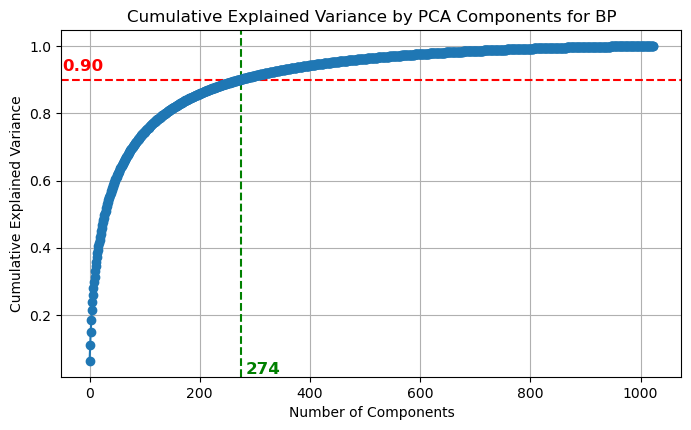

In [34]:
def pca_col(df, name, column_name='embeddings', variance_threshold=0.90):
    embeddings = np.array(df[column_name].tolist())
    
    scaler = StandardScaler()
    embeddings_standardized = scaler.fit_transform(embeddings)
    
    pca = PCA()
    pca.fit(embeddings_standardized)
    explained_variance = pca.explained_variance_ratio_

    # Components to retain (in our case 90% of variance)
    n_components = np.argmax(np.cumsum(explained_variance) >= variance_threshold) + 1
        
    plt.figure(figsize=(8, 4.5))
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    x_value = np.argmax(np.cumsum(explained_variance) >= variance_threshold) + 1
    plt.axvline(x=x_value, color='g', linestyle='--')
    plt.text(x_value + 10, 0.025, f'{x_value}', color='green', size='large', weight='bold')
    plt.text(- 50, variance_threshold + 0.025, f'{variance_threshold:.2f}', color='red', size='large', weight='bold')

    plt.plot(np.cumsum(explained_variance), marker='o')
    plt.title(f'Cumulative Explained Variance by PCA Components for {name}')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()
    
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings_standardized)
    
    # Integrate reduced embeddings into the DataFrame
    df[f'reduced_{column_name}'] = reduced_embeddings.tolist()
    return df

# Apply PCA and add column for each dataset
X_df_BP = pca_col(X_df_BP, 'BP')
#x_df_CC = pca_col(x_df_CC, 'CC')
#x_df_MF = pca_col(x_df_MF, 'MF')

##### Save the datasets

In [35]:
# Ensure the directory exists
datasets_path = Path('../data/datasets')
datasets_path.mkdir(parents=True, exist_ok=True)

# Save the DataFrame to a CSV file
X_df_BP.to_csv(datasets_path / 'X_df_BP.csv', index=False)
y_df_BP.to_csv(datasets_path / 'y_df_BP.csv', index=False)

# MODELS

In [36]:
import time

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from here

In [37]:
# Load data

X = X_df_BP['embeddings'] 
X = pd.DataFrame(X.tolist())  # Convert list of lists to DataFrame

# Preprocess target (MultiLabelBinarizer for multi-label classification)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_df_BP)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"y_df_CC: {y_df_CC[:5]}\ny.head: {y[:5]}")
print(f"type(y_df_CC): {type(y_df_CC)}, type(y): {type(y)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X shape: (83064, 1024), y shape: (83064, 1487)
y_df_CC: 0    (GO:0005575, GO:0110165, GO:0000785, GO:003299...
1    (GO:0005575, GO:0110165, GO:0071944, GO:000588...
2    (GO:0005575, GO:0110165, GO:0005622, GO:000582...
3     (GO:0005575, GO:0110165, GO:0005576, GO:0005615)
4    (GO:0005575, GO:0005737, GO:0042175, GO:003299...
Name: GO_term, dtype: object
y.head: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
type(y_df_CC): <class 'pandas.core.series.Series'>, type(y): <class 'numpy.ndarray'>


In [38]:
# Convert NumPy array to PyTorch tensor
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [39]:
# X_prova = X_train_tensor[:5000]
# y_prova = y_train_tensor[:5000]

# X_prova_test = X_test_tensor[:5000]
# y_prova_test = y_test_tensor[:5000]

# X_train_tensor = X_prova
# y_train_tensor = y_prova.to(device)
# X_test_tensor = X_prova_test
# y_test_tensor = y_prova_test.to(device)

## Models

In [40]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropouts, output_size):
        super(NN, self).__init__()
        
        layers = []
        in_size = input_size
        
        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropouts[i]))
            in_size = hidden_size
        
        layers.append(nn.Linear(in_size, output_size))
        layers.append(nn.Sigmoid())  # For multilabel classification
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

##### Creating/Extracting the models DataFrame

In [41]:
# Check if the file exists and create it if it doesn't
datasets_path = Path('../data/datasets')
nn_df_path = datasets_path / 'NN_BP.csv'

if nn_df_path.exists():
    
    NN_BP = pd.read_csv(nn_df_path)
    for c_list, c_int in zip(['hidden_sizes', 'dropouts'], ['batch_size', 'epochs']):
        NN_BP[c_list] = NN_BP[c_list].apply(ast.literal_eval)
        NN_BP[c_int] = NN_BP[c_int].astype(int)
    
    NN_BP['lr'] = NN_BP['lr'].astype(float)

else:
    if not datasets_path.exists():
        datasets_path.mkdir(parents=True, exist_ok=True)
    
    NN_BP = {
        'name': [],
        'hidden_sizes': [],
        'dropouts': [],
        'lr': [],
        'batch_size': [],
        'epochs': [],
        'macro_P': [],
        'macro_R': [],
        'macro_F1': [],
        'weighted_P': [],
        'weighted_R': [],
        'weighted_F1': [],
        'samples_P': [],
        'samples_R': [],
        'samples_F1': [],
        'training_time': [],
    }
    NN_BP = pd.DataFrame(NN_BP)


NN_BP.head()

,name,hidden_sizes,dropouts,lr,batch_size,epochs,macro_P,macro_R,macro_F1,weighted_P,weighted_R,weighted_F1,samples_P,samples_R,samples_F1,training_time


##### Filling NN_BP with model parameters

In [42]:
def insert_parameters(df, names, hidden_sizes_list, dropouts_list, lrs, batch_sizes, epochs_list):
    for name, hidden_sizes, dropouts, lr, batch_size, epochs in zip(names, hidden_sizes_list, dropouts_list, lrs, batch_sizes, epochs_list):
        exists = name in df['name'].values
        
        if not exists:
            new_row = {
                'name': name,
                'hidden_sizes': [hidden_sizes],
                'dropouts': [dropouts],
                'lr': lr,
                'batch_size': int(batch_size),
                'epochs': int(epochs),
            }
            new_row_df = pd.DataFrame(new_row)
            df = pd.concat([df, new_row_df], ignore_index=True)
        else:
            print(f"{name} already exists in the DataFrame.")
    
    return df

In [43]:

names = ['NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'NN6', 'NN7', 'NN8', 'NN9', 'NN10']


hidden_sizes = [[8192, 4096],   #NN1
                [4096, 2048],   #NN2
                [4096, 2048],   #NN3
                [2048, 1024],   #NN4
                [2048, 1024],   #NN5
                [2048, 1024],   #NN6
                [4096, 2048, 1024],   #NN7
                [4096, 2048, 2048],   #NN8
                [2048, 2048, 2048],   #NN9
                [2048, 4096, 2048],   #NN10
                [4096, 4096, 2048],   #NN11        
                [4096, 4096, 2048]]   #NN12    


dropouts = [[0.5, 0.4],   #NN1 
            [0.2, 0.2],   #NN2
            [0.4, 0.4],   #NN3
            [0.1, 0.1],   #NN4
            [0.2, 0.2],   #NN5
            [0.4, 0.4],   #NN6
            [0.1, 0.2, 0.3],  #NN7
            [0.2, 0.2, 0.2],  #NN8
            [0.2, 0.2, 0.2],  #NN9
            [0.3, 0.3, 0.3],  #NN10
            [0.1, 0.2, 0.3],  #NN11        
            [0.1, 0.2, 0.3]]  #NN12 


lrs = [0.001, #NN1 
       0.003, #NN2
       0.005, #NN3
       0.001, #NN4
       0.003, #NN5
       0.005, #NN6
       0.005, #NN7
       0.003, #NN8
       0.003, #NN9
       0.005, #NN10
       0.003, #NN11        
       0.001] #NN12 


batch_sizes = [512, #NN1
               2048, #NN2
               1024, #NN3
               2048, #NN4
               1024, #NN5
               1024, #NN6
               2048, #NN7
               1024, #NN8
               1024, #NN9
               2048, #NN10
               2048, #N11        
               1024] #N12 


epochs = [120,  #NN1 
          75,  #NN2
          100, #NN3
          75,  #NN4
          75,  #NN5
          100, #NN6
          75,  #NN7
          75,  #NN8
          75,  #NN9
          75,  #NN10
          75,  #NN11
          75]  #NN12



NN_BP = insert_parameters(df = NN_BP, 
               names = names, 
               hidden_sizes_list=hidden_sizes, 
               dropouts_list=dropouts, 
               lrs=lrs, 
               batch_sizes=batch_sizes, 
               epochs_list=epochs)

NN_BP.head()

,name,hidden_sizes,dropouts,lr,batch_size,epochs,macro_P,macro_R,macro_F1,weighted_P,weighted_R,weighted_F1,samples_P,samples_R,samples_F1,training_time
0,NN1,"[8192, 4096]","[0.5, 0.4]",0.001,512.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NN2,"[4096, 2048]","[0.2, 0.2]",0.003,2048.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NN3,"[4096, 2048]","[0.4, 0.4]",0.005,1024.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NN4,"[2048, 1024]","[0.1, 0.1]",0.001,2048.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NN5,"[2048, 1024]","[0.2, 0.2]",0.003,1024.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Training the models

In [44]:
def create_model(df, name, input_size, output_size):

    hidd_s = df[df['name'] == name]['hidden_sizes'].tolist()
    dropouts = df[df['name'] == name]['dropouts'].tolist()
    # Initialize the model
    model = NN(
        input_size = input_size,
        hidden_sizes = hidd_s,
        dropouts = dropouts, 
        output_size = output_size
        ).to(device)
    
    # Loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
    optimizer = optim.Adam(model.parameters(), lr=df[df['name'] == name]['lr'])

    return model, optimizer, criterion

In [45]:
def train_model(model, name, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    print(f"\nTraining {name} model:")

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        
        t = time.time() - start_time

        if epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f} - time: {(t/60):.2f}min")
        elif epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f} - time: {(t/60):.2f}min")

    end_time = time.time()  # Record the end time

    training_time = end_time - start_time  # Calculate the elapsed time
    
    return training_time / 60

In [46]:
def model_evaluation(df, name, model, X, y, target_names, training_time):

    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        probabilities = torch.sigmoid(y_pred)  # Assuming multilabel classification with sigmoid activation
        prob = probabilities[probabilities > 0.20].float()
        
        y_pred = (y_pred.cpu().numpy() > 0.5).astype(int)

    exists = any(df[df['name'] == name])
    
    if exists:
        
        report = classification_report(y.cpu().numpy(), y_pred, target_names=target_names, output_dict=True)
        # Convert the classification report to a DataFrame
        report = pd.DataFrame(report).transpose().drop(columns=['support'])
        
        report.loc['macro avg'] = report.loc['macro avg'].apply(lambda x: round(x, 3))
        report.loc['weighted avg'] = report.loc['weighted avg'].apply(lambda x: round(x, 3))
        report.loc['samples avg'] = report.loc['samples avg'].apply(lambda x: round(x, 3))



        df.loc[df['name'] == name, 'macro_P'] = report.loc['macro avg']['precision']
        df.loc[df['name'] == name, 'macro_R'] = report.loc['macro avg']['recall']
        df.loc[df['name'] == name, 'macro_F1'] = report.loc['macro avg']['f1-score']

        df.loc[df['name'] == name, 'weighted_P'] = report.loc['weighted avg']['precision']
        df.loc[df['name'] == name, 'weighted_R'] = report.loc['weighted avg']['recall']
        df.loc[df['name'] == name, 'weighted_F1'] = report.loc['weighted avg']['f1-score']
        
        df.loc[df['name'] == name, 'samples_P'] = report.loc['samples avg']['precision']
        df.loc[df['name'] == name, 'samples_R'] = report.loc['samples avg']['recall']
        df.loc[df['name'] == name, 'samples_F1'] = report.loc['samples avg']['f1-score']

        df.loc[df['name'] == name, 'training_time'] = training_time

        return df, report, prob
    else:
        print(f"{name} already exists in the DataFrame.")
        return df, None, prob

In [47]:
target_names = [str(cls) for cls in mlb.classes_]

report_path = datasets_path / 'BP_report.csv'
probs_path = datasets_path / 'BP_report.csv'


if report_path.exists() and probs_path.exists():
    report = pd.read_csv(datasets_path / 'BP_report.csv')
    probs = pd.read_csv(datasets_path / 'BP_probs.csv')
else:
    report = {}
    probs = {}

for name in NN_BP['name']:

    # Define model parameters
    input_size = X_train_tensor.shape[1] 
    hidden_sizes = NN_BP[NN_BP['name'] == name]['hidden_sizes'].values[0]
    dropouts = NN_BP[NN_BP['name'] == name]['dropouts'].values[0]
    output_size = y_train_tensor.shape[1]
    lr = float(NN_BP[NN_BP['name'] == name]['lr'].values[0])
    batch_size = int(NN_BP[NN_BP['name'] == name]['batch_size'].values[0])
    epochs = int(NN_BP[NN_BP['name'] == name]['epochs'].values[0])

    # Initialize the model
    model = NN(
        input_size = input_size,
        hidden_sizes = hidden_sizes,
        dropouts = dropouts, 
        output_size = output_size
        ).to(device)

    # Loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
    optimizer = optim.Adam(model.parameters(), lr=lr)

    

    # model, optimizer, criterion = create_model(NN_BP, name, X_train_tensor.shape[1] , y_train_tensor.shape[1])
    if np.isnan(NN_BP[NN_BP['name'] == name]['training_time'].values[0]):
        # Train the model
        training_time = train_model(model, name, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

        # Ensure X_test_tensor is on the same device as the model
        device = next(model.parameters()).device
        X_test_tensor = X_test_tensor.to(device)

        # Evaluation
        
        NN_BP, report[name], probs[name] = model_evaluation(NN_BP, name, model, X_test_tensor, y_test_tensor, target_names, training_time)

    # Save the DataFrame to a CSV file
NN_BP.to_csv(datasets_path / 'NN_BP.csv', index=False)
# Move tensors to CPU and convert to NumPy

def to_cpu_numpy(data):
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()  # Move to CPU & convert to NumPy
    return data  # If it's not a tensor, return as is

# Ensure report and probs are properly formatted
report = pd.DataFrame({k: [to_cpu_numpy(v)] for k, v in report.items()})
probs = pd.DataFrame({k: [to_cpu_numpy(v)] for k, v in probs.items()})



        
NN_BP.head()


Training NN1 model:
Epoch [1/120], Loss: 0.0809 - time: 0.07min
Epoch [10/120], Loss: 0.0608 - time: 0.87min
Epoch [20/120], Loss: 0.0501 - time: 1.66min
Epoch [30/120], Loss: 0.0421 - time: 2.46min
Epoch [40/120], Loss: 0.0355 - time: 3.26min
Epoch [50/120], Loss: 0.0315 - time: 4.06min
Epoch [60/120], Loss: 0.0287 - time: 4.87min
Epoch [70/120], Loss: 0.0255 - time: 5.68min
Epoch [80/120], Loss: 0.0235 - time: 6.49min
Epoch [90/120], Loss: 0.0227 - time: 7.29min
Epoch [100/120], Loss: 0.0209 - time: 8.10min
Epoch [110/120], Loss: 0.0200 - time: 8.90min

Training NN2 model:
Epoch [1/75], Loss: 0.0829 - time: 0.01min
Epoch [10/75], Loss: 0.0617 - time: 0.20min
Epoch [20/75], Loss: 0.0520 - time: 0.39min
Epoch [30/75], Loss: 0.0451 - time: 0.58min
Epoch [40/75], Loss: 0.0379 - time: 0.77min
Epoch [50/75], Loss: 0.0320 - time: 0.96min
Epoch [60/75], Loss: 0.0287 - time: 1.15min
Epoch [70/75], Loss: 0.0238 - time: 1.34min


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training NN3 model:
Epoch [1/100], Loss: 0.0812 - time: 0.02min
Epoch [10/100], Loss: 0.0619 - time: 0.25min
Epoch [20/100], Loss: 0.0555 - time: 0.48min
Epoch [30/100], Loss: 0.0517 - time: 0.70min
Epoch [40/100], Loss: 0.0482 - time: 0.93min
Epoch [50/100], Loss: 0.0461 - time: 1.16min
Epoch [60/100], Loss: 0.0447 - time: 1.38min
Epoch [70/100], Loss: 0.0427 - time: 1.61min
Epoch [80/100], Loss: 0.0411 - time: 1.83min
Epoch [90/100], Loss: 0.0401 - time: 2.06min


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training NN4 model:
Epoch [1/75], Loss: 0.0874 - time: 0.00min
Epoch [10/75], Loss: 0.0693 - time: 0.08min
Epoch [20/75], Loss: 0.0640 - time: 0.17min
Epoch [30/75], Loss: 0.0590 - time: 0.24min
Epoch [40/75], Loss: 0.0546 - time: 0.32min
Epoch [50/75], Loss: 0.0507 - time: 0.40min
Epoch [60/75], Loss: 0.0472 - time: 0.48min
Epoch [70/75], Loss: 0.0442 - time: 0.56min


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training NN5 model:
Epoch [1/75], Loss: 0.0810 - time: 0.01min
Epoch [10/75], Loss: 0.0618 - time: 0.10min
Epoch [20/75], Loss: 0.0545 - time: 0.19min
Epoch [30/75], Loss: 0.0499 - time: 0.28min
Epoch [40/75], Loss: 0.0440 - time: 0.37min
Epoch [50/75], Loss: 0.0401 - time: 0.46min
Epoch [60/75], Loss: 0.0375 - time: 0.55min
Epoch [70/75], Loss: 0.0352 - time: 0.64min


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training NN6 model:
Epoch [1/100], Loss: 0.0811 - time: 0.01min
Epoch [10/100], Loss: 0.0629 - time: 0.10min
Epoch [20/100], Loss: 0.0576 - time: 0.19min
Epoch [30/100], Loss: 0.0541 - time: 0.28min
Epoch [40/100], Loss: 0.0513 - time: 0.37min
Epoch [50/100], Loss: 0.0489 - time: 0.45min
Epoch [60/100], Loss: 0.0477 - time: 0.54min
Epoch [70/100], Loss: 0.0462 - time: 0.63min
Epoch [80/100], Loss: 0.0452 - time: 0.72min
Epoch [90/100], Loss: 0.0451 - time: 0.81min


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training NN7 model:
Epoch [1/75], Loss: 0.0820 - time: 0.01min
Epoch [10/75], Loss: 0.0682 - time: 0.21min
Epoch [20/75], Loss: 0.0582 - time: 0.41min
Epoch [30/75], Loss: 0.0517 - time: 0.60min
Epoch [40/75], Loss: 0.0474 - time: 0.80min
Epoch [50/75], Loss: 0.0433 - time: 1.00min
Epoch [60/75], Loss: 0.0400 - time: 1.19min
Epoch [70/75], Loss: 0.0371 - time: 1.39min


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training NN8 model:
Epoch [1/75], Loss: 0.0811 - time: 0.02min
Epoch [10/75], Loss: 0.0623 - time: 0.32min
Epoch [20/75], Loss: 0.0540 - time: 0.61min
Epoch [30/75], Loss: 0.0475 - time: 0.91min
Epoch [40/75], Loss: 0.0426 - time: 1.20min
Epoch [50/75], Loss: 0.0386 - time: 1.49min
Epoch [60/75], Loss: 0.0357 - time: 1.78min
Epoch [70/75], Loss: 0.0332 - time: 2.07min


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training NN9 model:
Epoch [1/75], Loss: 0.0811 - time: 0.02min
Epoch [10/75], Loss: 0.0634 - time: 0.23min
Epoch [20/75], Loss: 0.0549 - time: 0.43min
Epoch [30/75], Loss: 0.0498 - time: 0.64min
Epoch [40/75], Loss: 0.0451 - time: 0.85min
Epoch [50/75], Loss: 0.0417 - time: 1.06min
Epoch [60/75], Loss: 0.0406 - time: 1.27min
Epoch [70/75], Loss: 0.0369 - time: 1.47min


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training NN10 model:
Epoch [1/75], Loss: 0.0829 - time: 0.02min
Epoch [10/75], Loss: 0.0690 - time: 0.30min
Epoch [20/75], Loss: 0.0620 - time: 0.58min
Epoch [30/75], Loss: 0.0582 - time: 0.86min
Epoch [40/75], Loss: 0.0551 - time: 1.14min
Epoch [50/75], Loss: 0.0530 - time: 1.41min
Epoch [60/75], Loss: 0.0504 - time: 1.69min
Epoch [70/75], Loss: 0.0485 - time: 1.97min


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,name,hidden_sizes,dropouts,lr,batch_size,epochs,macro_P,macro_R,macro_F1,weighted_P,weighted_R,weighted_F1,samples_P,samples_R,samples_F1,training_time
0,NN1,"[8192, 4096]","[0.5, 0.4]",0.001,512.0,120.0,0.433,0.339,0.374,0.541,0.467,0.497,0.595,0.532,0.504,9.625752
1,NN2,"[4096, 2048]","[0.2, 0.2]",0.003,2048.0,75.0,0.562,0.214,0.289,0.617,0.362,0.433,0.670,0.424,0.454,1.418368
2,NN3,"[4096, 2048]","[0.4, 0.4]",0.005,1024.0,100.0,0.588,0.225,0.298,0.631,0.386,0.445,0.650,0.450,0.474,2.263855
3,NN4,"[2048, 1024]","[0.1, 0.1]",0.001,2048.0,75.0,0.434,0.090,0.130,0.599,0.269,0.326,0.709,0.330,0.392,0.594609
4,NN5,"[2048, 1024]","[0.2, 0.2]",0.003,1024.0,75.0,0.523,0.226,0.294,0.578,0.390,0.444,0.628,0.451,0.464,0.674865


In [48]:
# Move tensors to CPU and convert to NumPy
def to_cpu_numpy(data):
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()  # Move to CPU & convert to NumPy
    return data  # If it's not a tensor, return as is

# Ensure report and probs are properly formatted
if report is not None and isinstance(report, dict) and len(report) > 0:
    report = pd.DataFrame({k: [to_cpu_numpy(v)] for k, v in report.items()})
else:
    print("⚠️ Warning: report is empty! No models were trained.")
    report = pd.DataFrame()

if probs is not None and isinstance(probs, dict) and len(probs) > 0:
    probs = pd.DataFrame({k: [to_cpu_numpy(v)] for k, v in probs.items()})
else:
    print("⚠️ Warning: probs is empty!")
    probs = pd.DataFrame()


⚠️ Warning: report is empty! No models were trained.
⚠️ Warning: probs is empty!


##### Extracting results

In [49]:
metrics = ['macro_P', 'macro_R', 'macro_F1', 
           'weighted_P', 'weighted_R', 'weighted_F1', 
           'samples_P', 'samples_R', 'samples_F1']



BP_results = NN_BP.sort_values(by=metrics, ascending=False)[['macro_P', 'macro_R', 'macro_F1',
                                                             'weighted_P', 'weighted_R', 'weighted_F1', 
                                                             'samples_P', 'samples_R', 'samples_F1']][:5]

BP_params = NN_BP.sort_values(by=metrics, ascending=False)[['name', 'hidden_sizes', 'dropouts', 'lr', 
                                                'batch_size', 'epochs', 'training_time']][:5]

BP_params.head(), BP_results.head()

(   name        hidden_sizes         dropouts     lr  batch_size  epochs  \
 5   NN6        [2048, 1024]       [0.4, 0.4]  0.005      1024.0   100.0   
 2   NN3        [4096, 2048]       [0.4, 0.4]  0.005      1024.0   100.0   
 9  NN10  [2048, 4096, 2048]  [0.3, 0.3, 0.3]  0.005      2048.0    75.0   
 7   NN8  [4096, 2048, 2048]  [0.2, 0.2, 0.2]  0.003      1024.0    75.0   
 1   NN2        [4096, 2048]       [0.2, 0.2]  0.003      2048.0    75.0   
 
    training_time  
 5       0.889524  
 2       2.263855  
 9       2.082515  
 7       2.190863  
 1       1.418368  ,
    macro_P  macro_R  macro_F1  weighted_P  weighted_R  weighted_F1  samples_P  \
 5    0.603    0.183     0.249       0.635       0.362        0.418      0.658   
 2    0.588    0.225     0.298       0.631       0.386        0.445      0.650   
 9    0.581    0.104     0.151       0.665       0.275        0.336      0.713   
 7    0.566    0.214     0.288       0.620       0.363        0.433      0.665   
 1    0.562

In [50]:
row_names = [f'NN{i}' for i in range(1, BP_results.shape[0] + 1)]

# Add the row means to the DataFrame
BP_results['name'] = row_names
BP_params['name'] = row_names

# Save the DataFrame to a CSV file
BP_results.to_csv(datasets_path / 'BP_results.csv', index=False)
BP_params.to_csv(datasets_path / 'BP_params.csv', index=False)

# Print the updated DataFrame
BP_results.head(), BP_params.head()

(   macro_P  macro_R  macro_F1  weighted_P  weighted_R  weighted_F1  samples_P  \
 5    0.603    0.183     0.249       0.635       0.362        0.418      0.658   
 2    0.588    0.225     0.298       0.631       0.386        0.445      0.650   
 9    0.581    0.104     0.151       0.665       0.275        0.336      0.713   
 7    0.566    0.214     0.288       0.620       0.363        0.433      0.665   
 1    0.562    0.214     0.289       0.617       0.362        0.433      0.670   
 
    samples_R  samples_F1 name  
 5      0.426       0.458  NN1  
 2      0.450       0.474  NN2  
 9      0.342       0.400  NN3  
 7      0.431       0.460  NN4  
 1      0.424       0.454  NN5  ,
   name        hidden_sizes         dropouts     lr  batch_size  epochs  \
 5  NN1        [2048, 1024]       [0.4, 0.4]  0.005      1024.0   100.0   
 2  NN2        [4096, 2048]       [0.4, 0.4]  0.005      1024.0   100.0   
 9  NN3  [2048, 4096, 2048]  [0.3, 0.3, 0.3]  0.005      2048.0    75.0   
 7  NN4

##### LaTex tables

In [51]:
def generate_latex_table(df):
    metrics = ['macro_P', 'macro_R', 'macro_F1', 'weighted_P', 'weighted_R', 'weighted_F1', 'samples_P', 'samples_R', 'samples_F1']
    metric_names = ['Macro P', 'Macro R', 'Macro F1', 'Weighted P', 'Weighted R', 'Weighted F1', 'Samples P', 'Samples R', 'Samples F1']
    
    # Initialize the LaTeX table
    latex_table = "\\begin{tabular}{l" + "c" * len(df['name']) + "}\n"
    latex_table += "    \\toprule\n"
    latex_table += "    \\textit{Metric} & " + " & ".join([f"\\textit{{{name}}}" for name in df['name']]) + " \\\\\n"
    latex_table += "    \\midrule\n"
    
    for metric, metric_name in zip(metrics, metric_names):
        values = df[metric]
        formatted_values = [f"{value:.2f}" for value in values]
        latex_table += f"    {metric_name} & " + " & ".join(formatted_values) + " \\\\\n"
    
    latex_table += "    \\bottomrule\n"
    latex_table += "\\end{tabular}"
    
    return latex_table


def generate_parameters_latex_table(df):
    # Initialize the LaTeX table
    latex_table = "\\begin{table}[H]\n"
    latex_table += "    \\centering\n"
    latex_table += "    \\begin{tabular}{lcccccc}\n"
    latex_table += "        \\toprule\n"
    latex_table += "        \\textit{Model} & \\textit{Hidden Layer Sizes} & \\textit{Dropout} & \\textit{Learning Rate} & \\textit{Batch Size} & \\textit{Epochs} & \\textit{Regularization} \\\\\n"
    latex_table += "        \\midrule\n"
    
    for index, row in df.iterrows():
        model_name = row['name']
        hidden_sizes = row['hidden_sizes']
        dropouts = row['dropouts']
        lr = row['lr']
        batch_size = row['batch_size']
        epochs = row['epochs']
        regularization = 'None'  # Assuming regularization is not provided in the DataFrame
        
        latex_table += f"        {model_name} & {hidden_sizes} & {dropouts} & {lr} & {batch_size} & {epochs} & {regularization} \\\\\n"
    
    latex_table += "        \\bottomrule\n"
    latex_table += "    \\end{tabular}\n"
    latex_table += "    \\caption{Model Parameters.}\n"
    latex_table += "\\end{table}"
    
    return latex_table

# Generate the LaTeX table
latex_table = generate_latex_table(BP_results)
print(latex_table)

latex_table = generate_parameters_latex_table(BP_params)
print(latex_table)


\begin{tabular}{lccccc}
    \toprule
    \textit{Metric} & \textit{NN1} & \textit{NN2} & \textit{NN3} & \textit{NN4} & \textit{NN5} \\
    \midrule
    Macro P & 0.60 & 0.59 & 0.58 & 0.57 & 0.56 \\
    Macro R & 0.18 & 0.23 & 0.10 & 0.21 & 0.21 \\
    Macro F1 & 0.25 & 0.30 & 0.15 & 0.29 & 0.29 \\
    Weighted P & 0.64 & 0.63 & 0.67 & 0.62 & 0.62 \\
    Weighted R & 0.36 & 0.39 & 0.28 & 0.36 & 0.36 \\
    Weighted F1 & 0.42 & 0.45 & 0.34 & 0.43 & 0.43 \\
    Samples P & 0.66 & 0.65 & 0.71 & 0.67 & 0.67 \\
    Samples R & 0.43 & 0.45 & 0.34 & 0.43 & 0.42 \\
    Samples F1 & 0.46 & 0.47 & 0.40 & 0.46 & 0.45 \\
    \bottomrule
\end{tabular}
\begin{table}[H]
    \centering
    \begin{tabular}{lcccccc}
        \toprule
        \textit{Model} & \textit{Hidden Layer Sizes} & \textit{Dropout} & \textit{Learning Rate} & \textit{Batch Size} & \textit{Epochs} & \textit{Regularization} \\
        \midrule
        NN1 & [2048, 1024] & [0.4, 0.4] & 0.005 & 1024.0 & 100.0 & None \\
        NN2 & [409